In [1]:
import math
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import scipy.signal as signal
import matplotlib.pyplot as plt

import plotly
from scipy.fftpack import ifft, fft
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [250]:
class session():
    # An object for storing data and metadata for one session of EEG recording
    def __init__(self, filename):
        self.f = filename
        
    def get_data(self, type='OpenBCI', fix=['OpenBCI-col_names']):
        # Create a pandas dataframe with channel data (data_chns)
        # fix:
        #   - "OpenBCI-col_names" - removes spaces from column names and makes channel number's 1-indexed
        if type == 'OpenBCI':
            f = open(self.f)
            self.meta = [f.readline() for i in range(4)]
            self.n_chns = int(self.meta[1][22:])
            self.fs = int(self.meta[2][15:18]) # sample rate

            self.data_chns = pd.read_csv(self.f, skiprows=[0,1,2,3])
            self.data_chns = self.data_chns.drop(columns=['Sample Index'])
            
            if 'OpenBCI-col_names' in fix:
                for i in range(self.n_chns):
                    self.data_chns = self.data_chns.rename(columns={self.data_chns.keys()[i]:'eeg_channel_'+str(i+1)})
            
            if 'Time' not in self.data_chns.keys():
                self.data_chns.reset_index(inplace=True)
                self.data_chns = self.data_chns.rename(columns={'index':'Time'})
                self.data_chns['Time'] = self.data_chns['Time'].divide(self.fs)
                    
    def crop_data(self, upto=-1, after=-1):
        # Crop the data upto or after a certain time in seconds
        if upto > 0:
            self.data_chns = self.data_chns.query('Time>=@upto')
            print('Removed data upto ' + str(upto) + ' seconds.\n')
        if after > 0:
            self.data_chns = self.data_chns.query('Time<=@after')
            print('Removed data after ' + str(upto) + ' seconds.\n')
    
    def make_fft(self, test_fq=-1):
        timestep = 1/self.fs
        self.fft = df()
        
        NFFT = 0
        exp = 1
        while 2**exp < len(self.data_chns):
            NFFT = 2**exp
            exp += 1
        
        self.fft['Frequency'] = np.fft.fftfreq(NFFT)
        self.fft['Frequency'] = np.fft.fftshift(self.fft['Frequency'])
        self.fft = self.fft.query('Frequency>=0').mul(self.fs)
#         self.fft['Frequency'] = self.fft['Frequency'].mul(self.fs)[NFFT//2:]
#         self.fft = self.fft.query('Frequency>=0')
        for i in range(self.n_chns):
#             print(len(self.fft['Frequency']))
#             print(len(np.fft.fft(self.data_chns['eeg_channel_'+str(i+1)], n=NFFT)[:(NFFT//2)]))
            self.fft['eeg_channel_'+str(i+1)] = (np.real(np.fft.fft(self.data_chns['eeg_channel_'+str(i+1)], n=NFFT))**2)[:NFFT//2]
        
        if test_fq > 0:
            if test_fq < self.fs/2:
                self.test_fq = test_fq
                self.data_chns[str(test_fq)+'_Hz_test_fq'] = [np.sin(test_fq*2*np.pi*i/self.fs) for i in range(len(self.data_chns))]
                self.fft[str(test_fq)+'_Hz_test_fq'] = (np.real(np.fft.fft(self.data_chns[str(test_fq)+'_Hz_test_fq'], n=NFFT))**2)[:NFFT//2]
            else:
                print('WARNING: The test frequency is too high to be detected at a sample rate of '+str(self.fs)+' Hz.')
                
    
    def plot(self, ver='', chns=[]):
        # Plot the data in different helpful ways
        # Versions:
        #    pick-channels
        #    all-chns-in-one
        #    chn-grid
        #    fq
        #    fq-old
        #    test-fft
        
        if ver == 'pick-channels':
            fig = go.Figure(layout=go.Layout(title=go.layout.Title(text=str(len(chns)) + ' EEG Channels')
                        ))
            
            if len(chns) == 0:
                chns = range(1, self.n_chns + 1)
                print(chns)
            for i in range(len(chns)):
                fig.add_trace(go.Scatter(x=self.data_chns['Time'],
                                            y=self.data_chns['eeg_channel_'+str(chns[i])],
                                            mode='lines',
                                            name='EEG Ch.'+str(chns[i])))
            fig.show()

        if ver == 'all-chns-in-one':
            fig = go.Figure()
            for i in range(self.n_chns):
                fig.add_trace(go.Scatter(x=self.data_chns['Time'], y=self.data_chns['eeg_channel_'+str(i+1)],
                        mode='lines',
                        name='EEG Ch.'+str(i+1)))
            fig.show()
            
        if ver == 'chn-grid':
            if len(chns) == 0:
                fig = make_subplots(rows=self.n_chns, cols=1,
                                    vertical_spacing=0.01,
                                    subplot_titles=['EEG Channel '+str(i+1) for i in range(self.n_chns)])
                for i in range(self.n_chns):
                    fig.append_trace(go.Scatter(x=self.data_chns['Time'],
                                                y=self.data_chns['eeg_channel_'+str(i+1)],
                                                mode='lines',
                                                name='EEG Ch.'+str(i+1)),
                                                row=i+1,
                                                col=1)
                fig.update_layout(height=300*self.n_chns, width=800, title_text="Data by Channel")
                fig.show()
            else:
                fig = make_subplots(rows=len(chns), cols=1,
                                    vertical_spacing=0.2,
                                    subplot_titles=['EEG Channel '+str(i+1) for i in range(len(chns))])
                for i in range(len(chns)):
                    fig.append_trace(go.Scatter(x=self.data_chns['Time'],
                                                y=self.data_chns['eeg_channel_'+str(chns[i])],
                                                mode='lines',
                                                name='EEG Ch.'+str(chns[i])),
                                                row=i+1,
                                                col=1)
                fig.update_layout(height=300*len(chns), width=800, title_text="Data by Channel")
                fig.show()
                
        if ver == 'fq-old':
            for i in range(self.n_chns):
#                 plt.plot(self.fft['Frequency'], self.fft['eeg_channel_'+str(i+1)])
                plt.psd(self.data_chns['eeg_channel_'+str(i+1)], Fs=self.fs)
                plt.show()
        
        if ver == 'fq':
            if len(chns) == 0:
                fig = go.Figure()
                fig = make_subplots(rows=self.n_chns, cols=1,
                                    vertical_spacing=0.01,
                                    subplot_titles=['EEG Channel '+str(i+1) for i in range(self.n_chns)])
                for i in range(self.n_chns):
                    fig.append_trace(go.Scatter(x=self.fft['Frequency'], y=self.fft['eeg_channel_'+str(i+1)],
                            mode='lines',
                            name='EEG Ch.'+str(i+1)),
                            row=i+1,
                            col=1,)
                fig.update_layout(height=300*self.n_chns, width=800, title_text="Data by Channel")
                fig.show()
            else:
                fig = go.Figure()
                fig = make_subplots(rows=len(chns), cols=1,
                                    vertical_spacing=0.15,
                                    subplot_titles=['EEG Channel '+str(chns[i]) for i in range(len(chns))])
                for i in range(len(chns)):
                    fig.append_trace(go.Scatter(x=self.fft['Frequency'], y=self.fft['eeg_channel_'+str(chns[i])],
                            mode='lines',
                            name='EEG Ch.'+str(chns[i])),
                            row=i+1,
                            col=1,)
                fig.update_layout(height=300*len(chns), width=800, title_text="Data by Channel")
                fig.show()
                
        if ver == 'test-fft':
            n =len(S1.data_chns)

            X = np.linspace(0, n/self.fs, n)
#             Y = [np.sin(21*(2*np.pi)*i/S1.fs) for i in X]
            Y = [np.sin(self.test_fq*2*np.pi*i) for i in X]
            tst = df({'X':X, 'Y':Y})
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=tst['X'], y=tst['Y'],
                                    mode='lines',
                                    name='Test Frequency (' + str(self.test_fq) + ' Hz)'))
            fig.show()
            
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=self.fft['Frequency'], y=self.fft[str(self.test_fq)+'_Hz_test_fq'],
                                     mode='lines',
                                     name='Test Frequency (' + str(self.test_fq) + ' Hz)'))
            fig.show()
                

                

    def preprocess(self, hpf=0, lpf=0, rmv_avg=False, inplace=True):
        # Handle preprocessing to create a dataframe of processed data
        # Scale the data from -1 to 1
        # High-pass filter = hpf
        # Low-pass filter = lpf
        # Remove Average = rmv_avg
        
        # first_mod = True
        
        self.proc_data_chns = pd.DataFrame()
        self.proc_data_chns['Time'] = self.data_chns['Time']
        
        self.s_factor = S1.data_chns.drop(columns=S1.data_chns.keys()[17:]).drop(columns='Time').max().max() # max val for all chns
        for i in range(self.n_chns):
            self.proc_data_chns['eeg_channel_'+str(i+1)] = self.data_chns['eeg_channel_'+str(i+1)].div(self.s_factor)

        if rmv_avg:
            for i in range(self.n_chns):
                self.proc_data_chns['eeg_channel_'+str(i+1)] = self.proc_data_chns['eeg_channel_'+str(i+1)] - np.mean(self.proc_data_chns['eeg_channel_'+str(i+1)])
#                 print(np.mean(self.data_chns['eeg_channel_'+str(i+1)]))

        
        if lpf > 0 and hpf > 0:
            for i in range(self.n_chns):
                b, a = signal.butter(2, lpf, 'low', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.proc_data_chns['eeg_channel_'+str(i+1)])

                b, a = signal.butter(2, hpf, 'high', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.proc_data_chns['eeg_channel_'+str(i+1)])

        elif lpf > 0:
            for i in range(self.n_chns):
                b, a = signal.butter(2, lpf, 'low', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.proc_data_chns['eeg_channel_'+str(i+1)])
        elif hpf > 0:
            for i in range(self.n_chns):
                b, a = signal.butter(2, hpf, 'high', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.proc_data_chns['eeg_channel_'+str(i+1)])


        if inplace:
            self.data_chns = self.proc_data_chns
        return self.proc_data_chns

In [251]:
S1 = session('OpenBCI-RAW-2021-08-13_18-03-39.txt')
S1.get_data()
S1.crop_data(upto=1)
S1.preprocess(hpf=5, lpf=50, rmv_avg=True)

Removed data upto 1 seconds.



,Time,eeg_channel_1,eeg_channel_2,eeg_channel_3,eeg_channel_4,eeg_channel_5,eeg_channel_6,eeg_channel_7,eeg_channel_8,eeg_channel_9,eeg_channel_10,eeg_channel_11,eeg_channel_12,eeg_channel_13,eeg_channel_14,eeg_channel_15,eeg_channel_16
125,1.000,1.445251e-30,1.445251e-30,1.445251e-30,1.445251e-30,1.445251e-30,1.445251e-30,0.000002,0.000002,1.445251e-30,1.445251e-30,1.445251e-30,0.0,0.0,1.445251e-30,1.445251e-30,1.445251e-30
126,1.008,-5.796831e-30,-5.796831e-30,-5.796831e-30,-5.796831e-30,-5.796831e-30,-5.796831e-30,0.000690,0.000946,-5.796831e-30,-5.796831e-30,-5.796831e-30,0.0,0.0,-5.796831e-30,-5.796831e-30,-5.796831e-30
127,1.016,3.155444e-30,3.155444e-30,3.155444e-30,3.155444e-30,3.155444e-30,3.155444e-30,0.000177,0.000300,3.155444e-30,3.155444e-30,3.155444e-30,0.0,0.0,3.155444e-30,3.155444e-30,3.155444e-30
128,1.024,-3.155444e-30,-3.155444e-30,-3.155444e-30,-3.155444e-30,-3.155444e-30,-3.155444e-30,0.000348,0.000446,-3.155444e-30,-3.155444e-30,-3.155444e-30,0.0,0.0,-3.155444e-30,-3.155444e-30,-3.155444e-30
129,1.032,3.155444e-30,3.155444e-30,3.155444e-30,3.155444e-30,3.155444e-30,3.155444e-30,0.000285,0.000321,3.155444e-30,3.155444e-30,3.155444e-30,0.0,0.0,3.155444e-30,3.155444e-30,3.155444e-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,10.080,-2.832281e-30,-2.832281e-30,-2.832281e-30,-2.832281e-30,-2.832281e-30,-2.832281e-30,-0.000173,-0.000256,-2.832281e-30,-2.832281e-30,-2.832281e-30,0.0,0.0,-2.832281e-30,-2.832281e-30,-2.832281e-30
1261,10.088,3.884776e-30,3.884776e-30,3.884776e-30,3.884776e-30,3.884776e-30,3.884776e-30,-0.000186,-0.000266,3.884776e-30,3.884776e-30,3.884776e-30,0.0,0.0,3.884776e-30,3.884776e-30,3.884776e-30
1262,10.096,-1.902217e-30,-1.902217e-30,-1.902217e-30,-1.902217e-30,-1.902217e-30,-1.902217e-30,-0.000228,-0.000291,-1.902217e-30,-1.902217e-30,-1.902217e-30,0.0,0.0,-1.902217e-30,-1.902217e-30,-1.902217e-30
1263,10.104,5.060586e-30,5.060586e-30,5.060586e-30,5.060586e-30,5.060586e-30,5.060586e-30,-0.000436,-0.000614,5.060586e-30,5.060586e-30,5.060586e-30,0.0,0.0,5.060586e-30,5.060586e-30,5.060586e-30


In [254]:
S1.make_fft(test_fq=10)
S1.fft

,Frequency,eeg_channel_1,eeg_channel_2,eeg_channel_3,eeg_channel_4,eeg_channel_5,eeg_channel_6,eeg_channel_7,eeg_channel_8,eeg_channel_9,eeg_channel_10,eeg_channel_11,eeg_channel_12,eeg_channel_13,eeg_channel_14,eeg_channel_15,eeg_channel_16,10_Hz_test_fq
512,0.000000,1.893625e-59,1.893625e-59,1.893625e-59,1.893625e-59,1.893625e-59,1.893625e-59,2.533009e-06,4.330844e-06,1.893625e-59,1.893625e-59,1.893625e-59,0.0,0.0,1.893625e-59,1.893625e-59,1.893625e-59,0.232087
513,0.122070,1.893582e-59,1.893582e-59,1.893582e-59,1.893582e-59,1.893582e-59,1.893582e-59,2.536220e-06,4.336204e-06,1.893582e-59,1.893582e-59,1.893582e-59,0.0,0.0,1.893582e-59,1.893582e-59,1.893582e-59,0.232122
514,0.244141,1.893452e-59,1.893452e-59,1.893452e-59,1.893452e-59,1.893452e-59,1.893452e-59,2.546009e-06,4.352559e-06,1.893452e-59,1.893452e-59,1.893452e-59,0.0,0.0,1.893452e-59,1.893452e-59,1.893452e-59,0.232228
515,0.366211,1.893236e-59,1.893236e-59,1.893236e-59,1.893236e-59,1.893236e-59,1.893236e-59,2.562372e-06,4.379493e-06,1.893236e-59,1.893236e-59,1.893236e-59,0.0,0.0,1.893236e-59,1.893236e-59,1.893236e-59,0.232405
516,0.488281,1.892933e-59,1.892933e-59,1.892933e-59,1.892933e-59,1.892933e-59,1.892933e-59,2.583994e-06,4.417731e-06,1.892933e-59,1.892933e-59,1.892933e-59,0.0,0.0,1.892933e-59,1.892933e-59,1.892933e-59,0.232653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,61.889648,8.648105e-61,8.648105e-61,8.648105e-61,8.648105e-61,8.648105e-61,8.648105e-61,3.768610e-07,6.960486e-07,8.648105e-61,8.648105e-61,8.648105e-61,0.0,0.0,8.648105e-61,8.648105e-61,8.648105e-61,0.050622
1020,62.011719,8.656430e-61,8.656430e-61,8.656430e-61,8.656430e-61,8.656430e-61,8.656430e-61,3.759424e-07,6.943139e-07,8.656430e-61,8.656430e-61,8.656430e-61,0.0,0.0,8.656430e-61,8.656430e-61,8.656430e-61,0.050623
1021,62.133789,8.662907e-61,8.662907e-61,8.662907e-61,8.662907e-61,8.662907e-61,8.662907e-61,3.752610e-07,6.930293e-07,8.662907e-61,8.662907e-61,8.662907e-61,0.0,0.0,8.662907e-61,8.662907e-61,8.662907e-61,0.050623
1022,62.255859,8.667535e-61,8.667535e-61,8.667535e-61,8.667535e-61,8.667535e-61,8.667535e-61,3.747922e-07,6.921483e-07,8.667535e-61,8.667535e-61,8.667535e-61,0.0,0.0,8.667535e-61,8.667535e-61,8.667535e-61,0.050624


In [209]:
# test
np.mean(S1.data_chns['eeg_channel_7'])

4.938008479983614e-07

In [255]:
# plot
S1.plot(ver='test-fft', chns=[7,8])

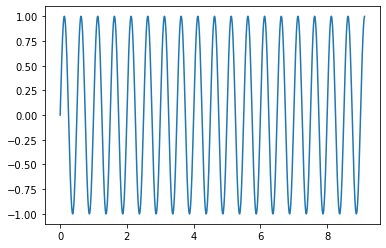

In [240]:
n =len(S1.data_chns)

fq = 25
fs = S1.fs

X = np.linspace(0, n, n)
# Y = [np.sin(2*np.pi*(i/fs*fq)) for i in X]
Y = [np.sin(21*(2*np.pi)*i/S1.fs) for i in X]
# Y = Y + np.mean(Y)

plt.plot(X/fs, Y)

In [229]:
S1.data_chns['eeg_channel_1'] = Y

In [230]:
S1.make_fft()

In [174]:
# plot
S1.plot(ver='fq', chns=[1,7,8])